# Выбор локации для скважины

Компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину. Имеются пробы нефти в трех регионах: в каждом 100 000 месторождений, где измерили качество нефти и объем ее запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесет наибольшую прибыль. Возможную прибыль и риски нужно проанализировать техникой *Bootstrap.*

Шаги для выбора локации:
- В избранном регионе ищут месторождения, для каждого определяют значения признаков
- Строят модель и оценивают объем запасов
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины
- Прибыль равна суммарной прибыли отобранных месторождений

Описание данных:
- `id` — уникальный идентификатор скважины
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы)
- `product` — объем запасов в скважине (тыс. баррелей).

Условия расчета прибыли:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объем указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-подготовка-данных" data-toc-modified-id="Загрузка-и-подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и подготовка данных</a></span></li><li><span><a href="#Обучение-и-проверка-модели" data-toc-modified-id="Обучение-и-проверка-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение и проверка модели</a></span></li><li><span><a href="#Подготовка-к-расчёту-прибыли" data-toc-modified-id="Подготовка-к-расчёту-прибыли-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка к расчёту прибыли</a></span></li><li><span><a href="#Расчёт-прибыли-и-рисков" data-toc-modified-id="Расчёт-прибыли-и-рисков-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Расчёт прибыли и рисков</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

## Загрузка и подготовка данных

Подключим необходимые модули, выставим полезные умолчания и определим базовые константы.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os

from urllib.error import HTTPError
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

plt.style.use('dark_background');            # Темный фон графиков
plt.rc('grid', color=(.3, .3, .3));          # Бледные линии сетки
plt.rc('axes', grid=True, axisbelow=True);   # Линии сетки позади графика
pd.set_option('display.max_columns', None);  # Показываем все столбцы

# Выключаем ворнинги
pd.options.mode.chained_assignment = None    
warnings.simplefilter('ignore', pd.errors.PerformanceWarning) 

RS = 22221111    # Кастомный random_state 
NUM_REGIONS = 3  # Число исследуемых в проекте регионов

# ----- Рекомендуемая PEP 8 максимальная длина строки кода – 79 символов ----->

Загрузим данные и взглянем на них.

In [2]:
DF = [0] * NUM_REGIONS

for i in range(NUM_REGIONS):
    path = f'/datasets/geo_data_{i}.csv'
    if not os.path.exists(path):
        path = 'https://code.s3.yandex.net' + path
    try:
        DF[i] = pd.read_csv(path)
    except HTTPError as err:
        print(f'{err} {path}')

In [3]:
for df in DF: display(df)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


In [4]:
for df in DF: display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Пропусков нет. Проверим на полные дубли.

In [5]:
for df in DF:
    print(df.duplicated().sum())

0
0
0


Дублей нет. Оптимизируем типы числовых столбцов.

In [6]:
for df in DF:
    df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, downcast='float')

Посмотрим на распределение значений столбцов. 

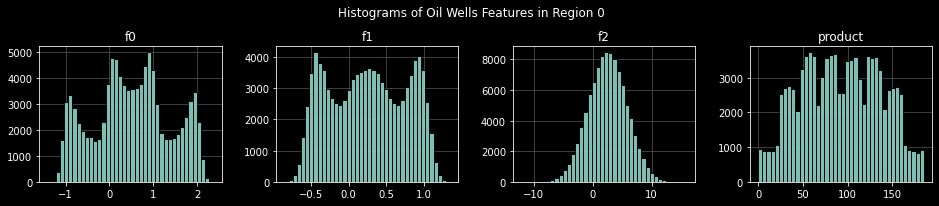

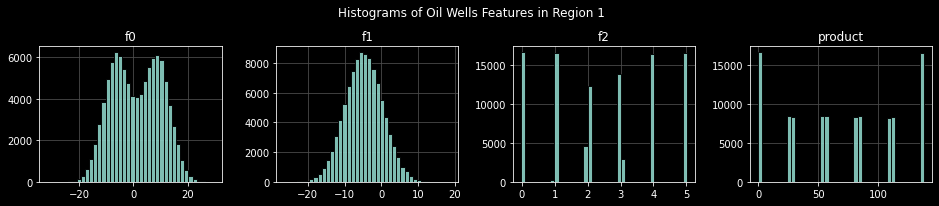

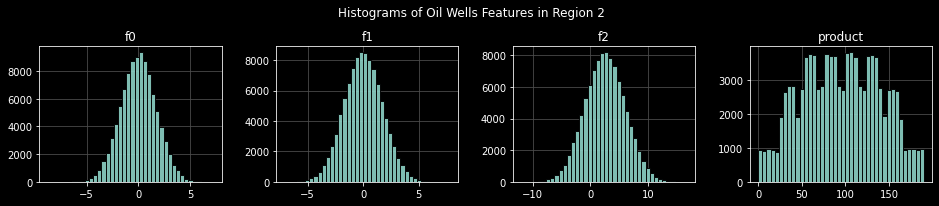

In [7]:
for i, df in enumerate(DF):
    df.iloc[:, 1:5].hist(bins=40, edgecolor='k', alpha=.9, 
                         figsize=(16, 2.5), layout=(1, 4));
    plt.suptitle(f'Histograms of Oil Wells Features in Region {i}', y=1.1)
    plt.show();

Нормальные и не очень распределения, а в регионе 1 еще и почти дискретные. Для лучшего понимания построим 3D-визуализацию, в которой три фичи скважин отложим по осям, а объем запасов покажем цветом.

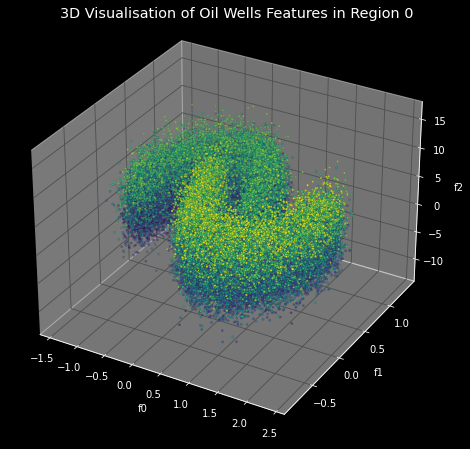

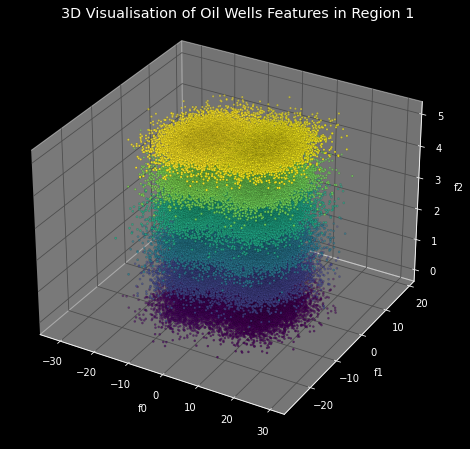

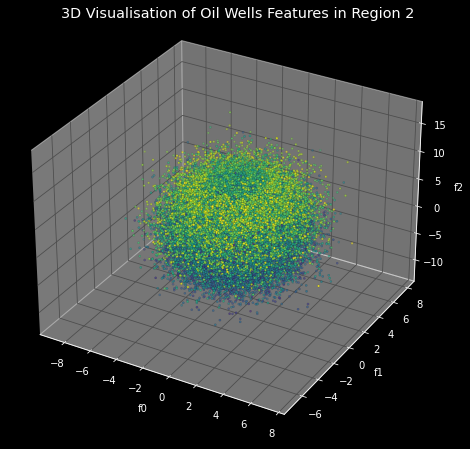

In [8]:
for i, df in enumerate(DF):
    fig = plt.figure(figsize=(10, 8));
    fig.suptitle(f'3D Visualisation of Oil Wells Features in Region {i}', 
                 y=.88, x=.53, fontsize='x-large');
    ax = fig.add_subplot(projection='3d');
    ax.scatter(df['f0'], df['f1'], df['f2'], c=df['product'],
              marker='.', edgecolors='k', linewidths=.1);
    ax.set(xlabel='f0', ylabel='f1', zlabel='f2');
#     ax.view_init(0, 120);  # Вращение на произвольный угол

В регионах 0 и 2 зависимость объема запасов от фич сложная. А вот в регионе 1 значимой, по всей видимости, является только фича `f2`, связь которой с объемом запасов выглядит простой. Посмотрим, насколько проста она на самом деле. 

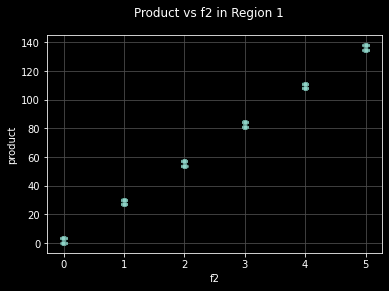

In [9]:
DF[1].plot(kind='scatter', x='f2', y='product', edgecolor='k', linewidth=.1);
plt.suptitle('Product vs f2 in Region 1');

Зависимость линейная – линейная регрессия должна отлично справиться с моделированием в этом регионе. 

Разделим данные в каждом регионе на фичи и таргет, потом на обучающую и тестовую выборки. Фичи в обеих выборках еще на всякий случай нормализуем по обучающей.

In [10]:
x = [0] * NUM_REGIONS
y = [0] * NUM_REGIONS
x_train = [0] * NUM_REGIONS
y_train = [0] * NUM_REGIONS
x_test = [0] * NUM_REGIONS
y_test = [0] * NUM_REGIONS

for i, df in enumerate(DF):
    x[i] = df.loc[:, 'f0':'f2']
    y[i] = df['product']
    
    x_train[i], x_test[i], y_train[i], y_test[i] = train_test_split(
        x[i], y[i], test_size=.25, random_state=RS+i)
    
    scaler = StandardScaler().fit(x_train[i])
    x_train[i][x_train[i].columns] = scaler.transform(x_train[i])    
    x_test[i][x_test[i].columns] = scaler.transform(x_test[i])

## Обучение и проверка модели

Перед обучением модели напишем функцию для расчета метрики регрессии, которую назовем `Normalized Median Absolute Percentage Error` (`NMAPE`). Метрика принимает значения от 0 до 1 и показывает характерный относительный масштаб ошибок предсказаний, причем симметричный относительно их знака (в отличие от `MAPE`).

In [11]:
def normalized_median_absolute_percentage_error(one, two):
    x = pd.concat([one, two], axis='columns', ignore_index=True)
    x.columns = [0, 1]
    x[2] = x.abs().max(axis=1)  
    x[3] = (x[0]-x[1]).abs()    
    x[4] = 0
    x.loc[x[2] > 0, 4] = x[3] / x[2]
    return x[4].median()

# Медленее
#     return x.apply(lambda r: r[3]/r[2] if r[2] > 0 else 0, axis=1).median()

# Очень медленно
#     return x.apply(lambda r: abs(r[0]-r[1])/r.abs().max() 
#                    if r.abs().max() > 0 else 0, axis=1).median()

Для каждого региона обучим линейную регрессию на обучающей выборке, после чего получим ее предсказания на тестовой. Затем рассчитаем средний объем запасов скважины на тестовой выборке, среднеквадратичную ошибку модели и NMAPE.

In [12]:
yp_test = [0] * NUM_REGIONS

for i in range(NUM_REGIONS):
    yp_test[i] = pd.Series(
        LinearRegression().fit(x_train[i], y_train[i]).predict(x_test[i]),
        index=y_test[i].index, name=y_test[i].name
    )
    rmse = mean_squared_error(y_test[i], yp_test[i], squared=False)
    nmape = normalized_median_absolute_percentage_error(y_test[i], yp_test[i])
    print()
    print(f'Region {i} modeled oil well reserves on test subset:')
    print(f'    mean:  {y_test[i].mean()}')
    print(f'    RMSE:  {rmse}')
    print(f'    NMAPE: {nmape}')    


Region 0 modeled oil well reserves on test subset:
    mean:  92.1430435180664
    RMSE:  37.7353401184082
    NMAPE: 0.2622649371623993

Region 1 modeled oil well reserves on test subset:
    mean:  68.67668151855469
    RMSE:  0.8942350149154663
    NMAPE: 0.010114900767803192

Region 2 modeled oil well reserves on test subset:
    mean:  94.95098114013672
    RMSE:  39.961212158203125
    NMAPE: 0.26436272263526917


Как и ожидалось, линейная регрессия лучше всего справилась с регионом 1: модель в нем ошибается в среднем всего на 1%. В двух других регионах NMAPE 26%, то есть характерная ошибка модели составляет несколько десятков процентов. Большая ошибка связана с тем, что в этих регионах связь фич с таргетом далека от линейной.

## Подготовка к расчёту прибыли

Сохраним условия расчета прибыли в константах.

In [13]:
WELLS_TO_EXPLORE = 500          # Скважин для разведки
WELLS_TO_DEVELOP = 200          # Скважин для разработки
GROSS_PROFIT_PER_KBBL = 450000  # Доход с 1000 баррелей сырья 
BUDGET = 10000000000            # Бюджет на разработку скважин 
MAX_ALLOWED_LOSS_PROB = .025    # Максимально допустимая вероятность убытков

Рассчитаем достаточный объем запасов для безубыточной разработки одной скважины.

In [14]:
MIN_ALLOWED_AVG_RESERVES_PER_DEVELOPED_WELL = (
    BUDGET / WELLS_TO_DEVELOP / GROSS_PROFIT_PER_KBBL
)
MIN_ALLOWED_AVG_RESERVES_PER_DEVELOPED_WELL

111.11111111111111

Объем получился заметно выше, чем среднее по скважинам в любом из регионов – отбирать скважины случайно не выйдет, модель должна будет неплохо предсказывать объем запасов, чтобы добыча в выбранном регионе в итоге оказалась прибыльным проектом.

## Расчёт прибыли и рисков 

Напишем функцию для расчета прибыли по выбранным скважинам и предсказаниям модели.

In [15]:
def ebit(true, pred):
    ind = pred.sort_values(ascending=False).index[:WELLS_TO_DEVELOP]
    return true[ind].sum()*GROSS_PROFIT_PER_KBBL - BUDGET

Примениv технику *bootstrap* с 1000 выборок, чтобы найти распределение прибыли. Рассчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона.

Region 0 bootstrapped EBIT:
    low 2.5%:       12,989,177
    mean:          607,872,898
    high 2.5%:   1,236,065,820
    loss prob:            2.4%


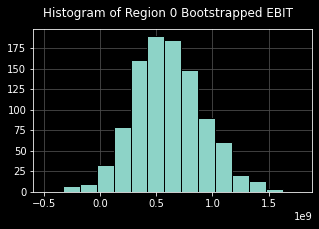


Region 1 bootstrapped EBIT:
    low 2.5%:      154,283,091
    mean:          650,176,136
    high 2.5%:   1,200,537,683
    loss prob:            0.3%


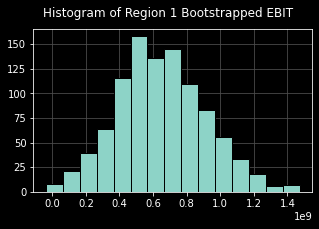


Region 2 bootstrapped EBIT:
    low 2.5%:      -51,379,829
    mean:          564,058,092
    high 2.5%:   1,235,431,382
    loss prob:            3.9%


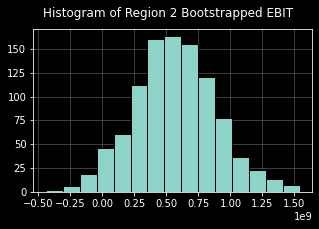

In [16]:
rs = np.random.RandomState(RS)
BOOTSTRAP_SAMPLES = 1000
ebits = [0] * BOOTSTRAP_SAMPLES 

for i in range(NUM_REGIONS):
    for j in range(BOOTSTRAP_SAMPLES):
        true = y_test[i].sample(n=WELLS_TO_EXPLORE, replace=True, 
                                random_state=rs)
        ebits[j] = ebit(true, yp_test[i][true.index])
    
    ebits = pd.Series(ebits)
    print(f'Region {i} bootstrapped EBIT:')
    print(f'    low 2.5%:  {ebits.quantile(.025):15,.0f}')
    print(f'    mean:      {ebits.mean():15,.0f}')
    print(f'    high 2.5%: {ebits.quantile(.975):15,.0f}')
    print(f'    loss prob: {(ebits < 0).sum()/len(ebits):15.1%}')
    ebits.hist(bins=15, edgecolor='k', figsize=(5, 3));
    plt.suptitle(f"Histogram of Region {i} Bootstrapped EBIT");
    plt.show();
    print()   

По вероятности убытков отбрасываем регион 2, а из оставшихся по средней прибыли выбираем победителем *регион 1* (у него и вероятность убытков ниже других). Рекомендуем ГлавРосГосНефти разрабатывать месторождение в регионе 1.

Необходимо отметить, что в регионе-победителе средний объем запасов скважины гораздо ниже, чем в двух других регионах. Победа досталась ему исключительно за счет высокой точности модели на данных в этом регионе.

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован